In [ ]:
import networkx as nx 
import matplotlib.pyplot as plt 
import pandas as pd
import geopandas as gpd
import numpy as np
%matplotlib inline 

In [4]:
stations = pd.read_csv('Stations_woIBX.csv', index_col=0); stations

,name,id,boro,lat,long,lines
0,Greenpoint Av,G26,Bk,40.731352,-73.954449,G
1,21 St,G24,Q,40.744065,-73.949724,G
2,Court Sq,G22,Q,40.746554,-73.943832,G
3,36 St,G20,Q,40.752039,-73.928781,M R
4,Queens Plaza,G21,Q,40.748973,-73.937243,E M R
...,...,...,...,...,...,...
493,City Hall,R24,M,40.713282,-74.006978,R W
494,Canal St,R23,M,40.719527,-74.001775,R W
495,Prince St,R22,M,40.724329,-73.997702,R W
496,8 St - NYU,R21,M,40.730328,-73.992629,R W


In [5]:
from mpl_toolkits.basemap import Basemap

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [61]:
#get list of Staten Island stations
SI_stations = stations.loc[stations['boro'] == 'SI']['id']

In [62]:
#excluding Staten Island, as its not connected to the rest of the NYC Subway
stations = stations.loc[stations['boro'] != 'SI']

In [20]:
connections = pd.read_csv('https://raw.githubusercontent.com/CUSP2021ADS/Data/main/NYCSubwayEdges.csv'); connections

,origin,dest
0,G26,G24
1,G26,G28
2,G24,G26
3,G24,G22
4,G22,G24
...,...,...
1843,R20,L03
1844,R20,R19
1845,R20,Q01
1846,R20,Q01


In [68]:
connections = connections.loc[(~connections['origin'].str.startswith('S')) | \
                              (~connections['dest'].str.startswith('S'))]

In [69]:
destinations = stations.merge(connections, left_on = 'id', right_on = 'dest') \
.loc[:,['name', 'dest', 'lat', 'long']] \
.drop_duplicates() \
.rename(columns = {'name':'dest_name', 'dest':'dest_id', 'lat':'dest_lat', 'long': 'dest_long'})

destinations.head()

,dest_name,dest_id,dest_lat,dest_long
0,Greenpoint Av,G26,40.731352,-73.954449
2,21 St,G24,40.744065,-73.949724
4,Court Sq,G22,40.746554,-73.943832
8,36 St,G20,40.752039,-73.928781
10,Queens Plaza,G21,40.748973,-73.937243


In [70]:
destinations.shape

(472, 4)

In [71]:
origins = stations.merge(connections, left_on = 'id', right_on = 'origin') \
.loc[:, ['name', 'origin', 'lat', 'long', 'dest']] \
.rename(columns = {'name': 'origin_name', 'origin':'origin_id', 'lat':'origin_lat', 'long':'origin_long'})

origins.head()

,origin_name,origin_id,origin_lat,origin_long,dest
0,Greenpoint Av,G26,40.731352,-73.954449,G24
1,Greenpoint Av,G26,40.731352,-73.954449,G28
2,21 St,G24,40.744065,-73.949724,G26
3,21 St,G24,40.744065,-73.949724,G22
4,Court Sq,G22,40.746554,-73.943832,G24


In [72]:
origins.shape

(1804, 5)

In [73]:
stations_od = origins.merge(destinations, left_on = 'dest', right_on = 'dest_id'); stations_od

,origin_name,origin_id,origin_lat,origin_long,dest,dest_name,dest_id,dest_lat,dest_long
0,Greenpoint Av,G26,40.731352,-73.954449,G24,21 St,G24,40.744065,-73.949724
1,Court Sq,G22,40.746554,-73.943832,G24,21 St,G24,40.744065,-73.949724
2,Greenpoint Av,G26,40.731352,-73.954449,G28,Nassau Av,G28,40.724635,-73.951277
3,Metropolitan Av,G29,40.712792,-73.951418,G28,Nassau Av,G28,40.724635,-73.951277
4,21 St,G24,40.744065,-73.949724,G26,Greenpoint Av,G26,40.731352,-73.954449
...,...,...,...,...,...,...,...,...,...
1799,Canal St,R23,40.719527,-74.001775,R24,City Hall,R24,40.713282,-74.006978
1800,Canal St,R23,40.719527,-74.001775,R22,Prince St,R22,40.724329,-73.997702
1801,8 St - NYU,R21,40.730328,-73.992629,R22,Prince St,R22,40.724329,-73.997702
1802,Prince St,R22,40.724329,-73.997702,R21,8 St - NYU,R21,40.730328,-73.992629


In [74]:
stations_connections = stations_od.groupby(by = ['origin_name', 'origin_id', 'origin_lat', 'origin_long']) \
.agg(lambda x: list(x)) \
.drop(columns = {'dest'})

stations_connections

dest_name  \
origin_name           origin_id origin_lat origin_long                                                      
1 Av                  L06       40.730953  -73.981628                                  [3 Av, Bedford Av]   
103 St                119       40.799446  -73.968379                             [96 St, Cathedral Pkwy]   
                      624       40.790600  -73.947478                                     [110 St, 96 St]   
                      A18       40.796092  -73.961454   [96 St, 96 St, Cathedral Pkwy (110 St), Cathed...   
103 St - Corona Plaza 706       40.749865  -73.862700                             [Junction Blvd, 111 St]   
...                                                                                                   ...   
Woodlawn              401       40.886037  -73.878751                                      [Mosholu Pkwy]   
Woodside - 61 St      712       40.745630  -73.902984                                      [52 St, 69 St]   
World Trade Center    E01       40.712582  -74.009781   [Park Pl, Park Pl, Canal St, Chambers St, Cham...   
York St               F18       40.701397  -73.986751                 [Jay St - MetroTech, East Broadway]   
Zerega Av             606       40.836488  -73.847036     [Westchester Sq - E Tremont Av, Castle Hill Av]   

                                                                          dest_id  \
origin_name           origin_id origin_lat origin_long                              
1 Av                  L06       40.730953  -73.981628                  [L05, L08]   
103 St                119       40.799446  -73.968379                  [120, 118]   
                      624       40.790600  -73.947478                  [623, 625]   
                      A18       40.796092  -73.961454        [A19, A19, A17, A17]   
103 St - Corona Plaza 706       40.749865  -73.862700                  [707, 705]   
...                                                                           ...   
Woodlawn              401       40.886037  -73.878751                       [402]   
Woodside - 61 St      712       40.745630  -73.902984                  [713, 711]   
World Trade Center    E01       40.712582  -74.009781   [228, 228, A34, A36, A36]   
York St               F18       40.701397  -73.986751                  [A41, F16]   
Zerega Av             606       40.836488  -73.847036                  [604, 607]   

                                                                                                 dest_lat  \
origin_name           origin_id origin_lat origin_long                                                      
1 Av                  L06       40.730953  -73.981628                              [40.732849, 40.717304]   
103 St                119       40.799446  -73.968379                              [40.793919, 40.803967]   
                      624       40.790600  -73.947478                               [40.79502, 40.785672]   
                      A18       40.796092  -73.961454        [40.791642, 40.791642, 40.800603, 40.800603]   
103 St - Corona Plaza 706       40.749865  -73.862700                               [40.749145, 40.75173]   
...                                                                                                   ...   
Woodlawn              401       40.886037  -73.878751                                          [40.87975]   
Woodside - 61 St      712       40.745630  -73.902984                              [40.744149, 40.746325]   
World Trade Center    E01       40.712582  -74.009781   [40.713051, 40.713051, 40.720824, 40.714111, 4...   
York St               F18       40.701397  -73.986751                              [40.692338, 40.713715]   
Zerega Av             606       40.836488  -73.847036                              [40.839892, 40.834255]   

                                                                                                dest_long  
origin_name           origin_id origin_lat ori

In [80]:
stations_connections.to_csv('stations_connections_list.csv')

In [81]:
station_pos = {stations['id'][c]: (stations['long'][c], stations['lat'][c]) for c in stations.index}
station_names = {stations['id'][c]: stations['name'][c] for c in stations.index}

In [82]:
subway_graph = nx.DiGraph()
for i in connections.index:
    subway_graph.add_edge(connections['origin'][i], connections['dest'][i])

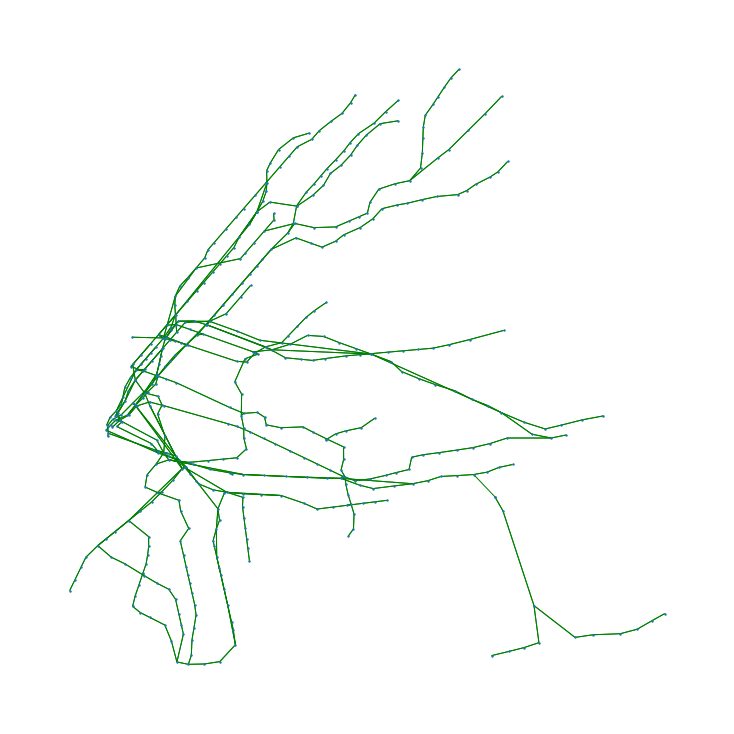

In [83]:
plt.figure(figsize = (10,10))
nx.draw(subway_graph, pos = station_pos, arrows = False, node_size = 2, width = 1,edge_color = 'green')